# **Gradient echoes and SSFP exercises: Balanced SSFP, FISP/PSIF, RF-Spoiling**

In this exercise you will change a standard 3D gradient echo scan (aka FISP, aka unbalanced SSFP) into different other SSFP sequences.

# Exercises

Starting point is the unbalanced gradient echo sequence (FISP).

## 1.1 Balanced SSFP
- Modify FISP to obtain bSSFP. If you do it right, you should see T2/T1 contrast and no banding artefacts.
- Make the banding artefacts visible (i.e. these dark stripes should appear in the image).
- change the location of the dark stripes (stopbands), i.e. in left-right direction

## 1.3 Introducing T1-weighting
- Modify the template sequence to obtain T1-contrast (while keeping the short TR!)

## 1.2 PSIF
- Modify the template sequence to see the PSIF signal
- What happens if you impose RF-spoiling to the PSIF-signal?

## 1.2 k=-2 sequence
- Modify the template sequence to use the k=-2 signal for imaging.


# Initialization

In [ ]:
import importlib
if importlib.util.find_spec('pypulseq') is None:
    !pip install -q mrzerocore git+https://github.com/imr-framework/pypulseq.git

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

import pypulseq as pp

!wget -nc https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
from utils import animate, simulate_2d, recon_cartesian_3d, plot_nd

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.1/349.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.0/234.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 13.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


--2024-02-06 16:48:18--  https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36249 (35K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  35.40K  --.-KB/s    in 0.003s  

2024-02-06 16:48:18 (10.9 MB/s) - ‘utils.py’ saved [36249/36249]



# **Create, simulate, and reconstruct sequence**

**GRE Sequence definition**

Timing check passed successfully


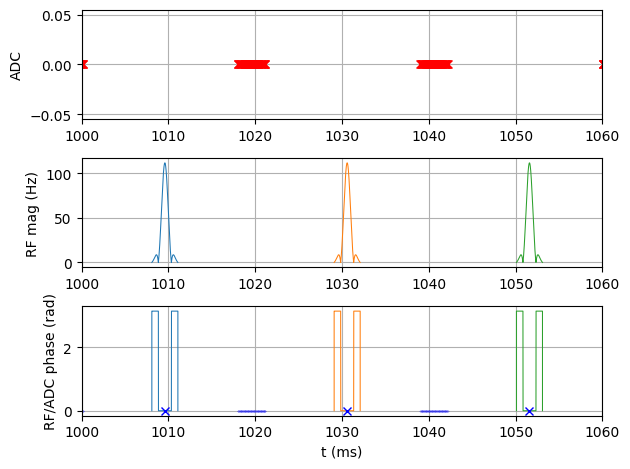

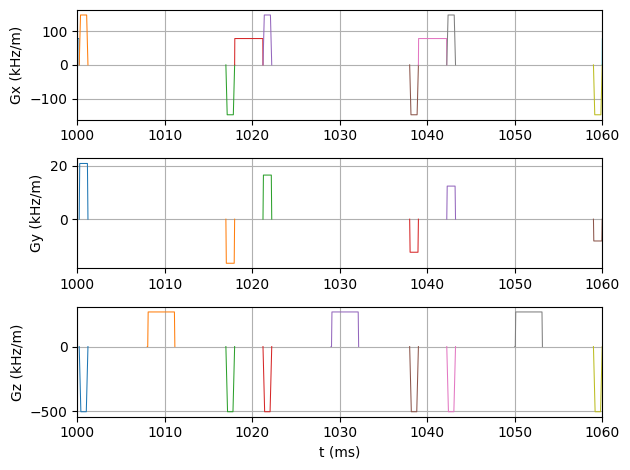

Number of blocks: 504
Number of events:
RF:     84
Gx:    252
Gy:    168
Gz:    252
ADC:     64
Delay:      0
Sequence duration: 1.764000 s
TE: 0.010000 s
TR: 0.021000 s
Flip angle: 30.00 deg
Unique k-space positions (aka cols, rows, etc.): 64 64 
Dimensions: 2
Spatial resolution: 4.06 mm
Spatial resolution: 4.00 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check passed successfully
Max gradient: 147978 145349 502058 Hz/m == 3.48 3.41 11.79 mT/m
Max slew rate: 3906250000 1038205980 5333333333 Hz/m/s == 91.75 24.38 125.27 T/m/s
Max absolute gradient: 543218 Hz/m == 12.76 mT/m
Max absolute slew rate: 5.33332e+09 Hz/m/s == 125.27 T/m/s


In [ ]:
plot = True
write_seq = True
seq_filename = "gre_3d.seq"

# ======
# SETUP
# ======

# Define FOV and resolution
fov = [256e-3, 256e-3, 5e-3]
Nx = 64
Ny = 64
Nz = 1
alpha = 30  # flip angle
TR = 20e-3  # Repetition time
TE = 10e-3  # Echo time
dummy_scans = 20 # Number of dummy repetitions

ro_os = 1 # Readout oversampling

# FISP
A = -0.5
C = 0.5
rf_inc = 0

#bSSFP
#A = ?
#C = ?
#rf_inc = ?

#PSIF
#?

#k=-2 sequence
#?


readout_duration = 3.2e-3 # Readout duration (sec)
pe_duration = 1e-3 # Duration of phase encoding gradients (sec)

# Create system object
system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=150,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

# Create a new sequence object
seq = pp.Sequence(system=system)

# ======
# CREATE EVENTS
# ======
rf, gz, _ = pp.make_sinc_pulse(
    flip_angle=alpha * math.pi / 180,
    duration=3e-3,
    slice_thickness=fov[2],
    apodization=0.42,
    time_bw_product=4,
    system=system,
    return_gz=True
)

# Define other gradients and ADC events
delta_kx = 1 / fov[0]
delta_ky = 1 / fov[1]
delta_kz = 1 / fov[2]

gx = pp.make_trapezoid(channel="x", flat_area=Nx * delta_kx, flat_time=readout_duration, system=system)
adc = pp.make_adc(num_samples=Nx * ro_os, duration=gx.flat_time, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel="x", area=-gx.area / 2, duration=pe_duration, system=system)

gx_spoil = pp.make_trapezoid(channel="x", area=2 * Nx * delta_kx, system=system)
gz_spoil = pp.make_trapezoid(channel="z", area=4 / fov[2], system=system)

# Phase encoding
phase_areas_y = (np.arange(Ny) - Ny // 2) * delta_ky
phase_areas_z = (np.arange(Nz) - Nz // 2) * delta_kz

# Phase encoding table with YZ order (outer loop = Z, inner loop = Y)
phase_encode_table = [(y,z) for z in range(len(phase_areas_z)) for y in range(len(phase_areas_y))]

# Calculate timing
delay_TE = (
    np.ceil(
        (
            TE
            - (pp.calc_duration(gz, rf) - pp.calc_rf_center(rf)[0] - rf.delay)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx) / 2
            - pp.eps
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
delay_TR = (
    np.ceil(
        (
            TR
            - pp.calc_duration(rf, gz)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx)
            - delay_TE
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)

# Exercises: Possible that you need to comment out these
assert delay_TE >= 0
assert delay_TR >= pp.calc_duration(gx_spoil, gz_spoil)

N_pe = len(phase_encode_table)

# ======
# CONSTRUCT SEQUENCE
# ======

# Initialize label values
last_lin = 0
last_slc = 0

# Initialize RF phase cycling
rf_phase = 0


# Loop over phase encodes and define sequence blocks
for i in range(-dummy_scans, N_pe):

    # rf spoiling
    # rf_phase = i*(i-1)*117/2
    # no rf spoiling
    rf_phase = (rf_phase + rf_inc) % 360.0

    rf.phase_offset = rf_phase / 180 * np.pi
    adc.phase_offset = rf_phase / 180 * np.pi

    # RF excitation and slice/slab selection gradient
    seq.add_block(rf, gz)

    # Wait for TE
    seq.add_block(pp.make_delay(delay_TE))

    # Phase encoding gradients, combined with slice selection rephaser
    pe_index_y, pe_index_z = phase_encode_table[max(i, 0)]
    #
    gx_pre = pp.make_trapezoid(channel="x", area=A * gx.area, duration=pe_duration, system=system)
    gy_pre = pp.make_trapezoid(channel="y", area=phase_areas_y[pe_index_y], duration=pe_duration, system=system)
    gz_pre = pp.make_trapezoid(channel="z", area=phase_areas_z[pe_index_z] - gz.area / 2, duration=pe_duration, system=system)
    seq.add_block(gx_pre, gy_pre, gz_pre)

    # Readout, do not enable ADC/labels for dummy acquisitions
    if i < 0:
        seq.add_block(gx)
    else:
        # Readout with LIN (Y) and SLC (Z) labels (increment relative to previous label value)
        seq.add_block(gx, adc, pp.make_label('LIN', 'INC', pe_index_y - last_lin), pp.make_label('SLC', 'INC', pe_index_z - last_slc))

    # Balance phase encoding and slice selection gradients
    gy_post = pp.make_trapezoid(channel="y", area=-phase_areas_y[pe_index_y], duration=pe_duration, system=system) #jl
    gz_post = pp.make_trapezoid(channel="z", area=-phase_areas_z[pe_index_z] - gz.area / 2, duration=pe_duration, system=system) #jl
    gx_post = pp.make_trapezoid(channel="x", area=C * gx.area, duration=pe_duration, system=system)
    seq.add_block(gx_post, gy_post, gz_post)

    # wait for TR
    seq.add_block(pp.make_delay(delay_TR))

    # Update previous labels
    last_lin = pe_index_y
    last_slc = pe_index_z


# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# ======
# VISUALIZATION
# ======
if plot:
    #seq.plot()
    seq.plot(time_range=np.array([50, 53])*TR, time_disp="ms")


# Very optional slow step, but useful for testing during development e.g. for the real TE, TR or for staying within
# slew-rate limits
print(seq.test_report())

# =========
# WRITE .SEQ
# =========
seq.set_definition(key="FOV", value=fov)

if write_seq:
    # Prepare the sequence output for the scanner
    seq.set_definition(key="Name", value="gre_3d")
    seq.write(seq_filename)

**Plot k-space trajectory**

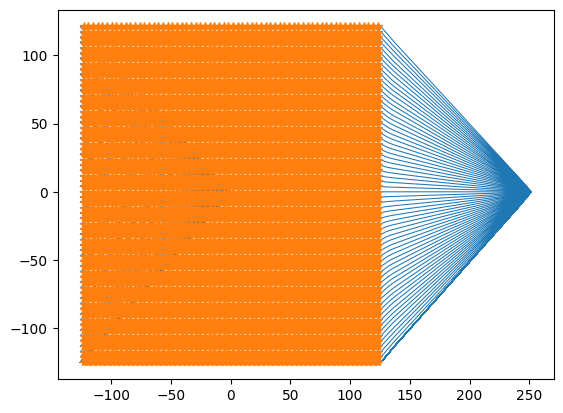

In [ ]:
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'*');

**Check gradient 0th moments over one TR**

In [ ]:
# Excitation events are filled with NaN in k_traj, find trajectory before second NaN
# Note: Because this is one sample before the excitation, if a gradient is enabled, the moment calculation will be off by the area of one sample (amplitude * grad_raster_time)!
end_of_tr_inds = np.flatnonzero(np.isnan(k_traj[0])) - 1
k_traj_after_first_tr = k_traj[:, end_of_tr_inds[1]]

print(f'X moment: {k_traj_after_first_tr[0]: 8.2f}/m   {k_traj_after_first_tr[0]/(Nx*delta_kx): 8.2f} cycles/voxel')
print(f'Y moment: {k_traj_after_first_tr[1]: 8.2f}/m   {k_traj_after_first_tr[1]/(Ny*delta_ky): 8.2f} cycles/voxel')
print(f'Z moment: {k_traj_after_first_tr[2]: 8.2f}/m   {k_traj_after_first_tr[2]/(Nz*delta_kz): 8.2f} cycles/voxel')

X moment:   251.56/m       1.01 cycles/voxel
Y moment:     0.00/m       0.00 cycles/voxel
Z moment:    -0.53/m      -0.00 cycles/voxel


**Animate trajectory**

In [ ]:
ani = animate(seq, show=False, dt=seq.duration()[0] / 10, plot_window=seq.duration()[0], fps=10, show_progress=True)
from IPython.display import HTML
HTML(ani.to_html5_video())

  0%|          | 0/10 [00:00<?, ?it/s]

**Run MR-zero simulation**

The code below simulates the whole sequence, and shows the magnitude of the raw k-space profiles in acquisition order.

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


Calculating repetition 84 / 84 - done


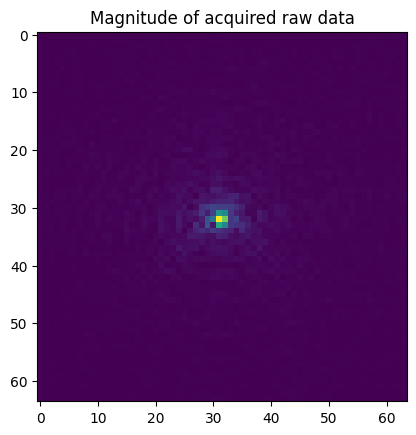

In [ ]:
# Simulate sequence
kdata = simulate_2d(seq, sim_size=[128,128], noise_level=0.5, n_coils=1, B0_scale=1)

# Display raw data profiles
plt.figure()
plt.imshow(abs(kdata[0]))
plt.title('Magnitude of acquired raw data');

**Reconstruct simulated data**

Detected labels in the sequence!
Automatically detected matrix size: ['SLC', 'LIN', 'ADC'] [1, 64, 64]


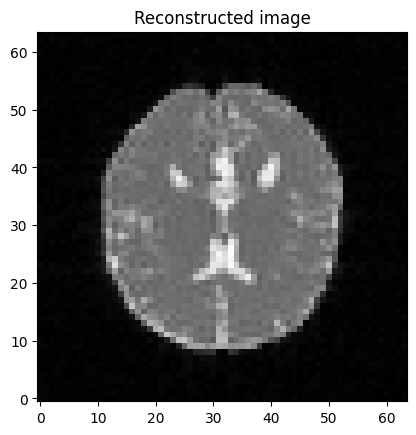

In [ ]:
rec = recon_cartesian_3d(kdata, seq)

plot_nd(rec)
plt.title('Reconstructed image');